# Small exmaple of Contextual Loss (CX)
[Open with Colab](https://colab.research.google.com/github/S-aiueo32/contextual_loss_pytorch/blob/master/doc/small_example.ipynb)

I will show you a small example of CX here.

## Calculate CX
For the first, import dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Create images called $x$ and $y$ in the paper.
You can see the pixels whose spatial correspondings have similar looks.
For simplicity, I will use the RGB values as the features through this notebook.

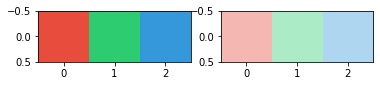

In [2]:
x = np.array([
              [231, 76, 60],
              [46, 204, 113],
              [52, 152, 219],
]).reshape(1, 3, 3) / 255
y = np.array([
              [245, 183, 177],
              [171, 235, 198],
              [174, 214, 241],
]).reshape(1, 3, 3) / 255

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x)
plt.subplot(1, 2, 2)
plt.imshow(y)

Along with the key idea, convert $x$, $y$ to $X$, $Y$ respectively.

In [3]:
X = x.reshape(-1, 3)
Y = y.reshape(-1, 3)

Calculate cosine distances between all points.

In [4]:
# normalize
mu = Y.mean(axis=0, keepdims=True)
X_centered = X -mu
Y_centered = Y -mu
X_normalized = X_centered / np.linalg.norm(X_centered, ord=2, axis=1, keepdims=True)
Y_normalized = Y_centered / np.linalg.norm(Y_centered, ord=2, axis=1, keepdims=True)

# cosine distance
d = 1 - np.matmul(X_normalized, Y_normalized.transpose())

Looking at the heatmap of `d`, you confirm the correspondings are similar.

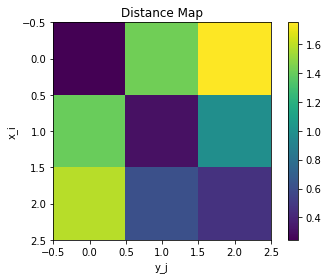

In [5]:
plt.imshow(d)
plt.colorbar()
plt.title('Distance Map');
plt.ylabel('x_i');
plt.xlabel('y_j');

Along with Eq.(2) in the paper, normalize using the minimum.
Through this process, the most similar point over $y_j$ becomes `1.`

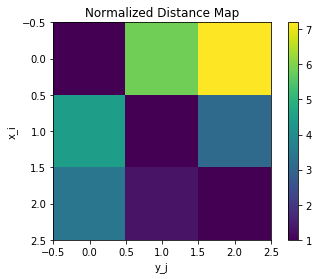

In [6]:
d_tilde = d / (d.min(axis=1, keepdims=True) + 1e-5)

plt.imshow(d_tilde)
plt.colorbar()
plt.title('Normalized Distance Map');
plt.ylabel('x_i');
plt.xlabel('y_j');

Convert to similarity showed in Eq.(3).

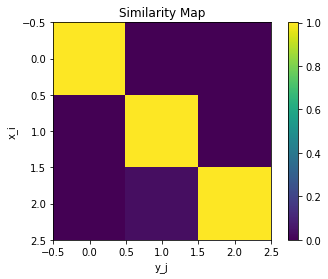

In [7]:
w = np.exp((1 - d_tilde) / 0.1)

plt.imshow(w)
plt.colorbar()
plt.title('Similarity Map');
plt.ylabel('x_i');
plt.xlabel('y_j');

The bandwidth parameter is set as `0.1` above.
The setting is very important to get the acceptable result i.e. the inappropriate value prevents Top-1 feature enhancement like below.

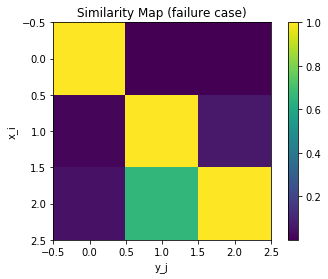

In [8]:
w_ = np.exp((1 - d_tilde) / 0.8)

plt.imshow(w_)
plt.colorbar()
plt.title('Similarity Map (failure case)');
plt.ylabel('x_i');
plt.xlabel('y_j');

Normalize and get final result.

In [9]:
cx_ij = w / np.sum(w, axis=1, keepdims=True)  # normalize
cx = np.mean(np.max(cx_ij, axis=0))
print(f'CX: {cx}')

CX: 0.9878605414928291


## The Robustness of CX
CX is the metric invariant misalignment of images.
To show the robustness, shuffle the pixels of $y$ and measure CX on all patterns.

In [10]:
from itertools import permutations

def compute_cx(x, y):  # integrate as a function
    X = x.reshape(-1, 3)
    Y = y.reshape(-1, 3)

    mu = Y.mean(axis=0, keepdims=True)
    X_centered = X -mu
    Y_centered = Y -mu
    X_normalized = X_centered / np.linalg.norm(X_centered, ord=2, axis=1, keepdims=True)
    Y_normalized = Y_centered / np.linalg.norm(Y_centered, ord=2, axis=1, keepdims=True)

    d = 1 - np.matmul(X_normalized, Y_normalized.transpose())
    d_tilde = d / (d.min(axis=1, keepdims=True) + 1e-5)
    w = np.exp((1 - d_tilde) / 0.1)
    cx_ij = w / np.sum(w, axis=1, keepdims=True)

    return np.mean(np.max(cx_ij, axis=0))

for i, p in enumerate(permutations([0, 1, 2])):
    y_ = y[:, p, :]
    cx = compute_cx(x, y_)
    print(f'[trial {i}]: {cx}')

[trial 0]: 0.9878605414928291
[trial 1]: 0.9878605414928291
[trial 2]: 0.9878605414928291
[trial 3]: 0.9878605414928291
[trial 4]: 0.9878605414928291
[trial 5]: 0.9878605414928291


Did you cnofirm all of CXs is same? It's robustness!

That's all, happy CX!